# Cat and Dog Classification - week 5
Classify images of cats and dogs using Histogram of Oriented Gradients (HOG) for feature extraction and Decision Tree, Random Forest, Linear Regression for classification and compair them.

In [4]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from google.colab import files
import zipfile, os

In [5]:
uploaded = files.upload()
# extract zipfile
with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

Saving dataset.zip to dataset.zip


In [17]:
# Load dataset
data_dir = './dataset/dataset'
images, labels = [], []

for file in os.listdir(data_dir):
    if file.endswith('.jpg'):
        img_path = os.path.join(data_dir, file)
        if file.startswith('cat'):
            labels.append(0)  # Cat
        elif file.startswith('dog'):
            labels.append(1)  # Dog
        else:
            continue

        img = imread(img_path)
        img = rgb2gray(img)  # Convert to grayscale
        images.append(img)

images = np.array(images)
labels = np.array(labels)
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print(f'Number of cats: {np.sum(labels == 0)}')
print(f'Number of dogs: {np.sum(labels == 1)}')

Images shape: (615, 128, 128)
Labels shape: (615,)
Number of cats: 260
Number of dogs: 355


In [18]:
# Extract HOG features
hog_features = []
hog_images = []
for img in images:
    features, hog_img = hog(
        img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        transform_sqrt=True,
        visualize=True
    )
    hog_features.append(features)
    hog_images.append(hog_img)

hog_features = np.array(hog_features)
hog_images = np.array(hog_images)
print('HOG features shape:', hog_features.shape)
print('HOG images shape:', hog_images.shape)

HOG features shape: (615, 8100)
HOG images shape: (615, 128, 128)


In [20]:
#Check the number of samples in each class
cat_idx = np.where(labels == 0)[0]   # indices of cats
dog_idx = np.where(labels == 1)[0]   # indices of dogs

print(f"Total cats: {len(cat_idx)}, Total dogs: {len(dog_idx)}")

#Select equal number of samples from each class
min_count = min(len(cat_idx), len(dog_idx))
np.random.seed(42)
cat_idx_bal = np.random.choice(cat_idx, min_count, replace=False)
dog_idx_bal = np.random.choice(dog_idx, min_count, replace=False)

# Combine the selected indices for balanced dataset
balanced_idx = np.concatenate([cat_idx_bal, dog_idx_bal])

#Create balanced dataset
hog_features_bal = hog_features[balanced_idx]
labels_bal      = labels[balanced_idx]
images_bal      = images[balanced_idx]
hog_images_bal  = hog_images[balanced_idx]

#Train/test split with stratify to maintain exact 50/50 ratio
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    hog_features_bal,
    labels_bal,
    np.arange(len(labels_bal)),  # indices for later reference
    test_size=0.2,
    random_state=42,
    stratify=labels_bal          # preserve class ratio
)

# Split images and HOG images according to train/test indices
images_train     = images_bal[idx_train]
images_test      = images_bal[idx_test]
hog_images_train = hog_images_bal[idx_train]
hog_images_test  = hog_images_bal[idx_test]

#Print report
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print(f"Training set - Cats: {np.sum(y_train == 0)}, Dogs: {np.sum(y_train == 1)}")
print(f"Test set - Cats: {np.sum(y_test == 0)}, Dogs: {np.sum(y_test == 1)}")


Total cats: 260, Total dogs: 355
Training set shape: (416, 8100)
Test set shape: (104, 8100)
Training set - Cats: 208, Dogs: 208
Test set - Cats: 52, Dogs: 52


In [19]:
# TODO: Train models using scikit-learn
# 1) Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)  # initialize decision tree
dt_model.fit(X_train, y_train)                      # train on HOG features
y_pred_dt = dt_model.predict(X_test)               # predict on test set
dt_accuracy = accuracy_score(y_test, y_pred_dt)    # calculate accuracy

# 2) Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # initialize RF with 100 trees
rf_model.fit(X_train, y_train)                                        # train
y_pred_rf = rf_model.predict(X_test)                                   # predict
rf_accuracy = accuracy_score(y_test, y_pred_rf)                        # accuracy


# 3) Linear Regression
lr_model = LinearRegression()              # initialize linear regression
lr_model.fit(X_train, y_train)             # train
y_pred_lr_cont = lr_model.predict(X_test)  # predict continuous output

# Convert continuous outputs to 0 or 1 using threshold 0.5
y_pred_lr = (y_pred_lr_cont >= 0.5).astype(int)
lr_accuracy = accuracy_score(y_test, y_pred_lr)  # accuracy


# Display accuracies
print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')
print(f'Linear Regression Accuracy: {lr_accuracy:.4f}')


Decision Tree Accuracy: 0.7981
Random Forest Accuracy: 0.9231
Linear Regression Accuracy: 0.9038


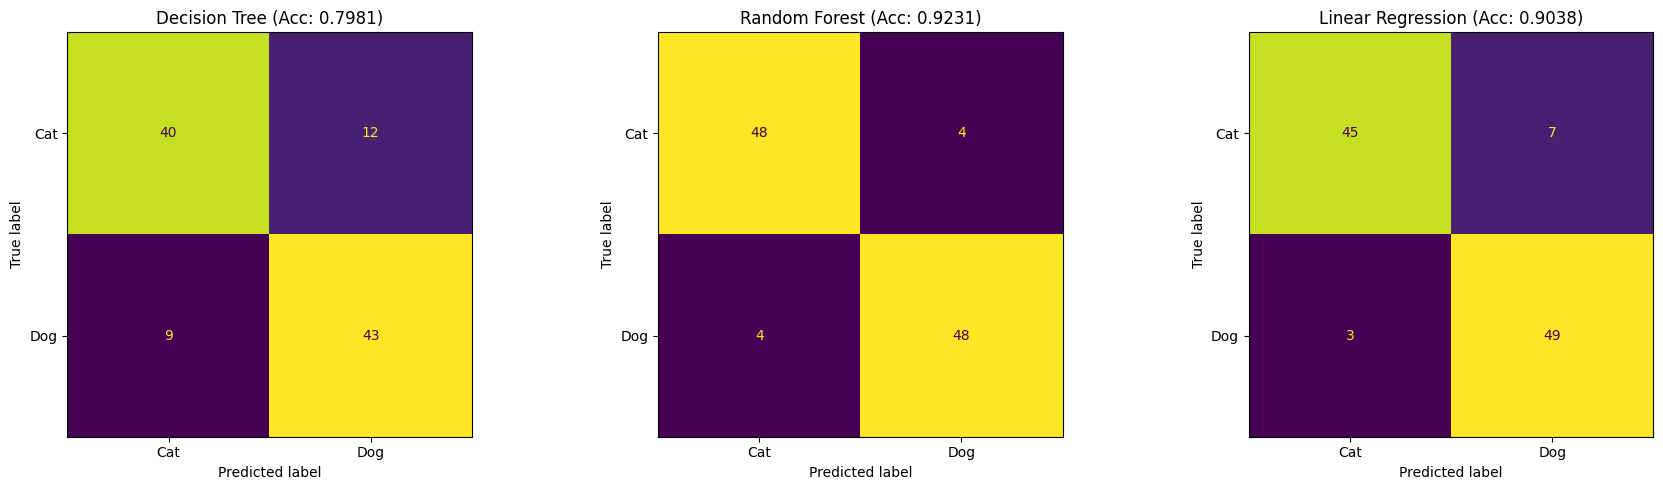

In [22]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # create a figure with 3 subplots

# 1) Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)  # compute confusion matrix
ConfusionMatrixDisplay(cm_dt, display_labels=['Cat', 'Dog']).plot(ax=axes[0], colorbar=False)
axes[0].set_title(f'Decision Tree (Acc: {dt_accuracy:.4f})')


# 2) Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)  # compute confusion matrix
ConfusionMatrixDisplay(cm_rf, display_labels=['Cat', 'Dog']).plot(ax=axes[1], colorbar=False)
axes[1].set_title(f'Random Forest (Acc: {rf_accuracy:.4f})')

# 3) Linear Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)  # compute confusion matrix
ConfusionMatrixDisplay(cm_lr, display_labels=['Cat', 'Dog']).plot(ax=axes[2], colorbar=False)
axes[2].set_title(f'Linear Regression (Acc: {lr_accuracy:.4f})')

# Final display
plt.tight_layout()
plt.show()


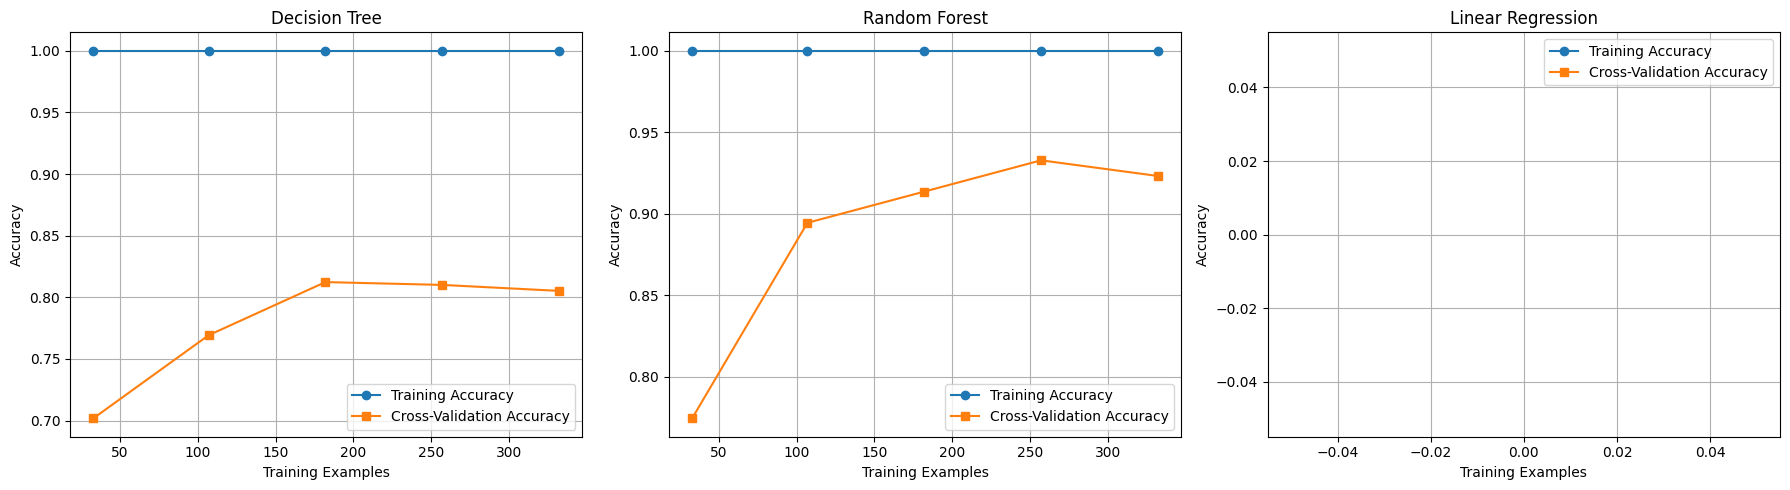

In [23]:
# Define a function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, ax, train_sizes=np.linspace(0.1, 1.0, 5)):
    # Compute training and cross-validation scores
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,      # the model to evaluate
        X, y,           # features and labels
        cv=5,           # 5-fold cross-validation
        n_jobs=-1,      # use all CPU cores
        train_sizes=train_sizes,  # fractions of training data
        scoring='accuracy'        # evaluation metric
    )

    # Compute mean accuracy for training and validation sets
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean  = test_scores.mean(axis=1)

    # Plot training accuracy
    ax.plot(train_sizes, train_scores_mean, label='Training Accuracy', marker='o')
    # Plot cross-validation accuracy
    ax.plot(train_sizes, test_scores_mean, label='Cross-Validation Accuracy', marker='s')

    # Set titles and labels
    ax.set_title(title)
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='best')
    ax.grid(True)


# Plot Learning Curve for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # create 3 subplots

# Decision Tree
plot_learning_curve(dt_model, "Decision Tree", X_train, y_train, axes[0])
# Random Forest
plot_learning_curve(rf_model, "Random Forest", X_train, y_train, axes[1])
# Linear Regression
plot_learning_curve(lr_model, "Linear Regression", X_train, y_train, axes[2])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


### It seams there is wrong with Linear Regression learning curve, Can you guess why?!

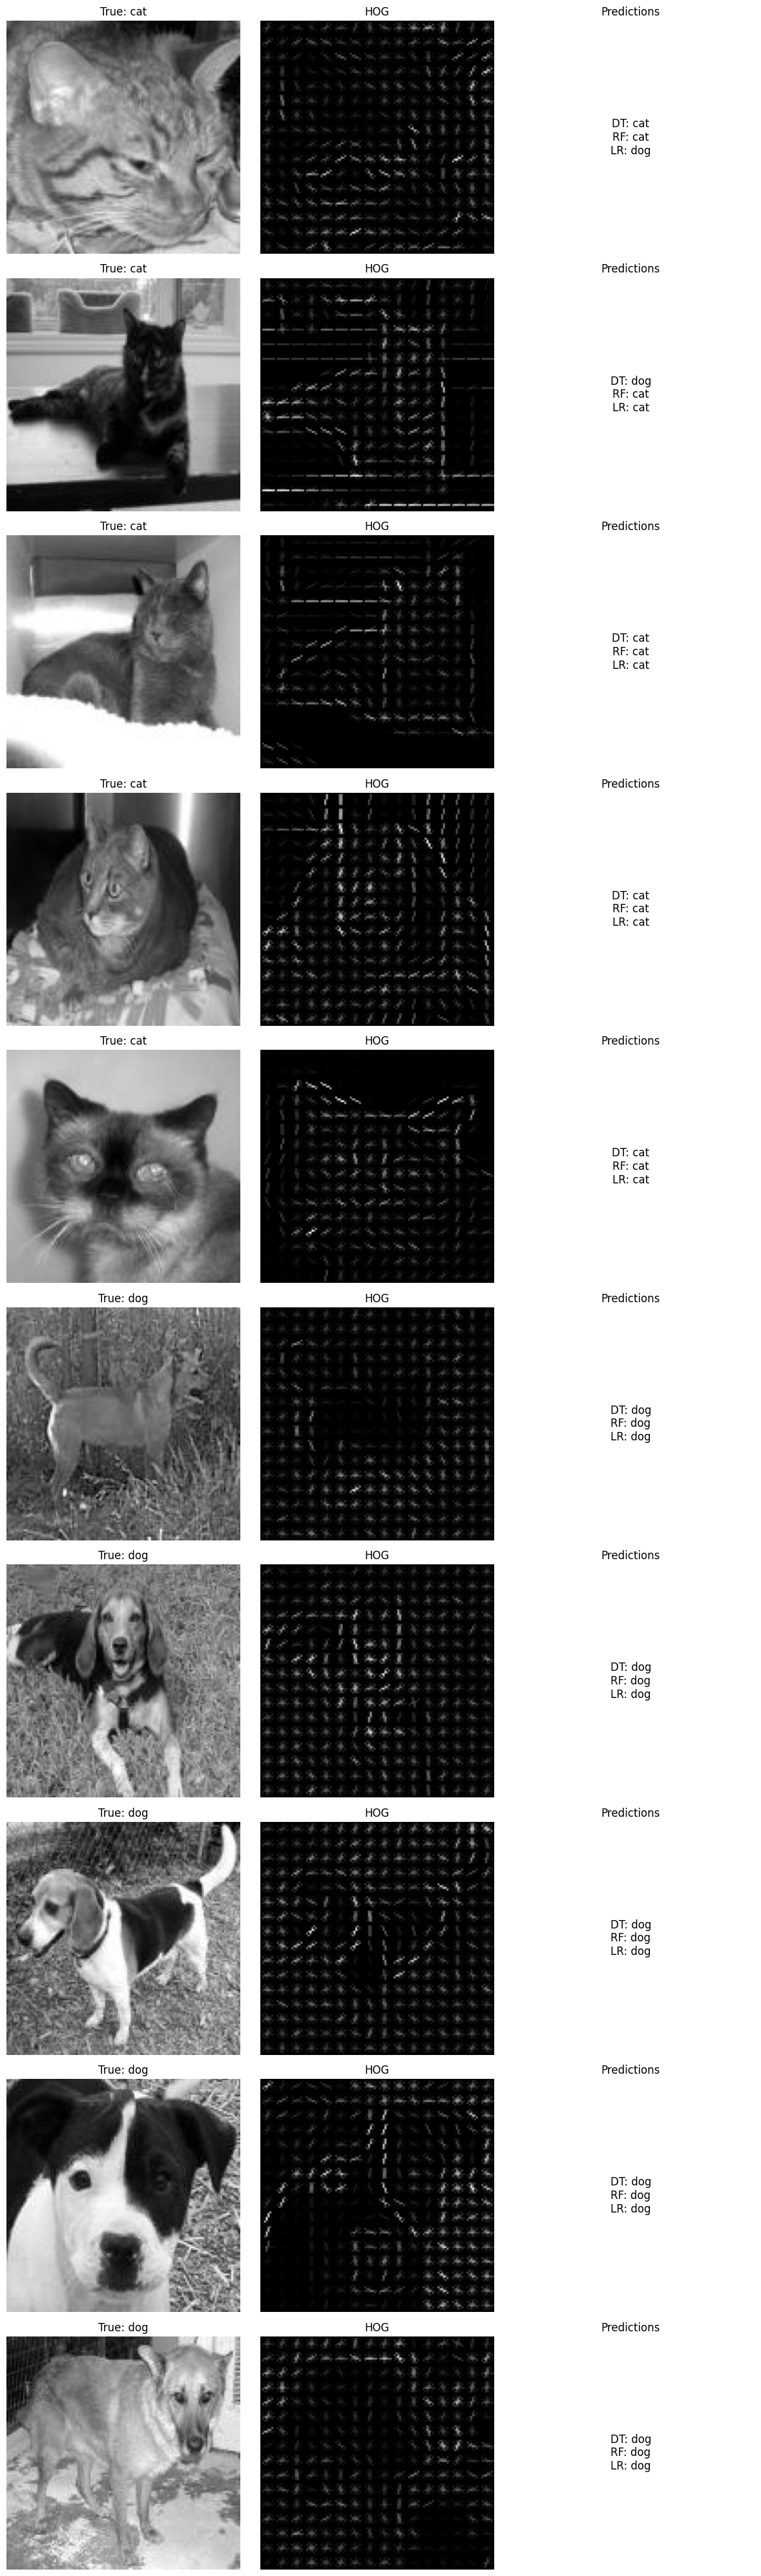

In [24]:
# Visualize sample results
classes = ['cat', 'dog']
cat_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 0]
dog_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 1]
sample_indices = cat_indices[:min(5, len(cat_indices))] + dog_indices[:min(5, len(dog_indices))]

fig, axes = plt.subplots(len(sample_indices), 3, figsize=(12, 4 * len(sample_indices)))
for i, idx in enumerate(sample_indices):
    true_label = y_test[np.where(idx_test == idx)[0][0]]
    dt_pred_label = y_pred_dt[np.where(idx_test == idx)[0][0]]
    rf_pred_label = y_pred_rf[np.where(idx_test == idx)[0][0]]
    lr_pred_label = y_pred_lr[np.where(idx_test == idx)[0][0]]

    # Original image
    ax = axes[i, 0] if len(sample_indices) > 1 else axes[0]
    ax.imshow(images_test[np.where(idx_test == idx)[0][0]], cmap='gray')
    ax.set_title(f'True: {classes[true_label]}')
    ax.axis('off')

    # HOG image
    ax = axes[i, 1] if len(sample_indices) > 1 else axes[1]
    ax.imshow(hog_images_test[np.where(idx_test == idx)[0][0]], cmap='gray')
    ax.set_title('HOG')
    ax.axis('off')

    # Predictions
    ax = axes[i, 2] if len(sample_indices) > 1 else axes[2]
    ax.text(0.5, 0.5, f'DT: {classes[dt_pred_label]}\nRF: {classes[rf_pred_label]}\nLR: {classes[lr_pred_label]}',
            fontsize=12, ha='center', va='center')
    ax.set_title('Predictions')
    ax.axis('off')

plt.tight_layout()
plt.show()
